# CIFAR-10 Classification Project

This project aims to work on image recognition models using the CIFAR-10 dataset. CNN architectures and transfer-learning methods, using pre-trained models on imagenet will be used.

## 1. Import & Setup

In [3]:
# import all relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Activation, GlobalAveragePooling2D, Input
)

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_dense
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
# seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load & Visualize Data

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes:
"airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In [5]:
# load & split data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# define class names
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


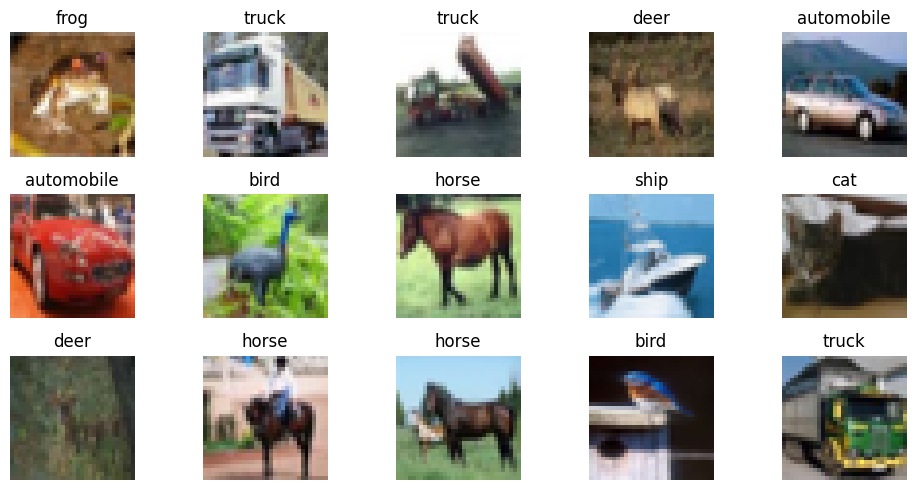

In [6]:
# visualize examples
plt.figure(figsize=(10, 5))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# dataset shapes
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (50000, 32, 32, 3) X_test: (10000, 32, 32, 3)
y_train: (50000, 1) y_test: (10000, 1)


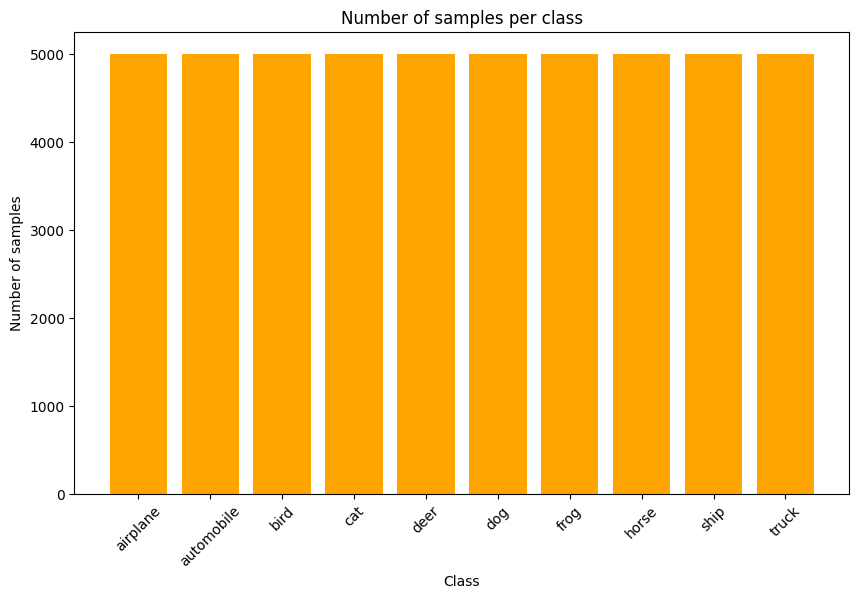

In [8]:
# class distribution
labels = y_train.flatten()
class_counts = Counter(labels)
plt.figure(figsize=(10, 6))
plt.bar(class_names, [class_counts[i] for i in range(10)], color="orange")
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(rotation=45)
plt.show()

The classes are evenly distributed.

## 3. Preprocessing

For the data reprocessing, flattening of the target data to 1D is needed as preparation for encoding the classes.

Normalization of the features will help training the models.



In [9]:
# flatten label arrays
y_train = y_train.flatten()
y_test = y_test.flatten()

In [10]:
# one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [11]:
# normalize pixel color values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## 4. Evaluation of Models

For constant cross-checking between chosen model architectures and finetuning parameters, a evaluation function is defined, lisitng the accuracy according to step iteration step.

In [14]:
results = []

def evaluate_model(model, model_name, X_test, y_test=None, save_model=False, filename=None):
    import numpy as np  # ensure numpy is imported

    # Case 1: Dataset-style input (no y_test)
    if y_test is None:
        loss, acc = model.evaluate(X_test, verbose=0)
        results.append({
            "Model": model_name,
            "Loss": loss,
            "Accuracy": acc
        })
        print(f"{model_name} -> Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

        if save_model and filename:
            model.save(filename)
            print(f"Saved model to {filename}")

        return None, None

    # Case 2: Numpy-style input (X_test, y_test)
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)  # FIXED

    loss, acc = model.evaluate(X_test, y_test, verbose=0)  # FIXED
    results.append({
        "Model": model_name,
        "Loss": loss,
        "Accuracy": acc
    })
    print(f"{model_name} -> Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    if save_model and filename:
        model.save(filename)
        print(f"Saved model to {filename}")

    return y_pred, y_true

In [15]:
# early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

## 5. Baseline CNN Model

In [22]:
# creating baseline model architecture
model_base = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


In [23]:
# compile
model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_base = model_base.fit(X_train, y_train_cat, epochs=20, validation_split=0.2, shuffle=True)
evaluate_model(model_base, "Baseline CNN", X_test, y_test_cat)

# save baseline model
model_base.save("CIFAR-10_base_model.keras")

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3720 - loss: 1.7249 - val_accuracy: 0.5676 - val_loss: 1.2429
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5859 - loss: 1.1826 - val_accuracy: 0.6246 - val_loss: 1.0807
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6475 - loss: 1.0083 - val_accuracy: 0.6473 - val_loss: 1.0280
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6862 - loss: 0.9011 - val_accuracy: 0.6595 - val_loss: 0.9915
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7197 - loss: 0.8103 - val_accuracy: 0.6627 - val_loss: 0.9886
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7473 - loss: 0.7320 - val_accuracy: 0.6696 - val_loss: 0.9934
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7711 - loss: 0.6603 - val_accuracy: 0.6693 - val_loss: 1.0221
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7942 - loss: 0.5928 - 

#### Baseline Evaluation & Visualization


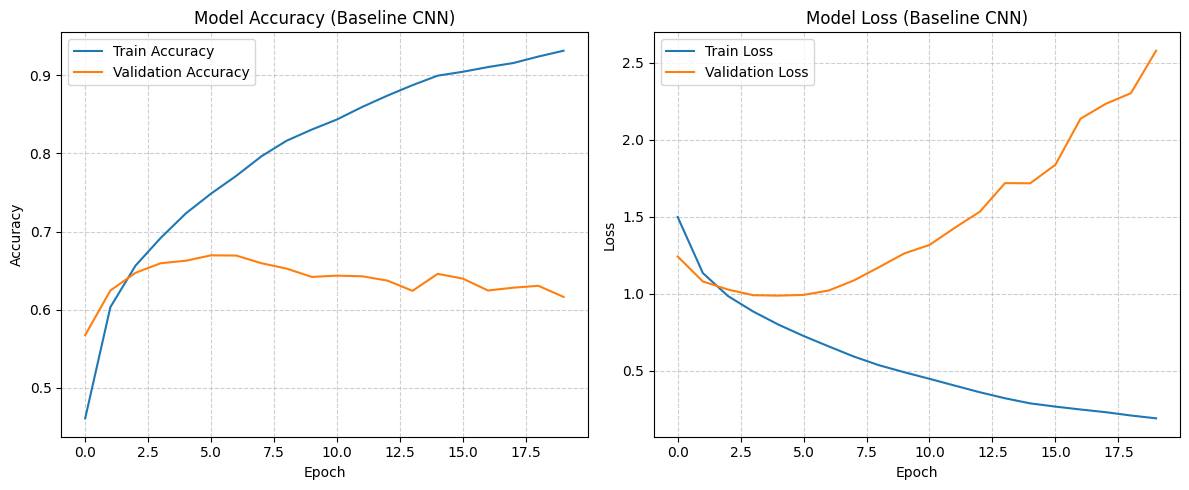

In [24]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Baseline CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Baseline CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [25]:
# Predict class probabilities
y_pred_probs = model_base.predict(X_test)

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1) # transfer probabilities back to classes
y_true = y_test  # original integer labels

#report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

    airplane       0.70      0.68      0.69      1000
  automobile       0.60      0.86      0.70      1000
        bird       0.52      0.52      0.52      1000
         cat       0.58      0.28      0.38      1000
        deer       0.58      0.54      0.56      1000
         dog       0.61      0.37      0.46      1000
        frog       0.69      0.77      0.73      1000
       horse       0.52      0.82      0.64      1000
        ship       0.73      0.73      0.73      1000
       truck       0.73      0.64      0.68      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.61     10000
weighted avg       0.63      0.62      0.61     10000



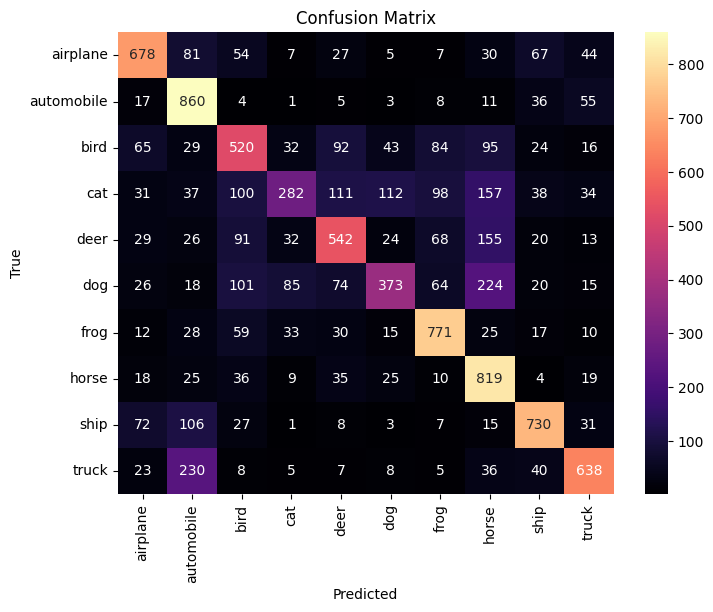

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="magma")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

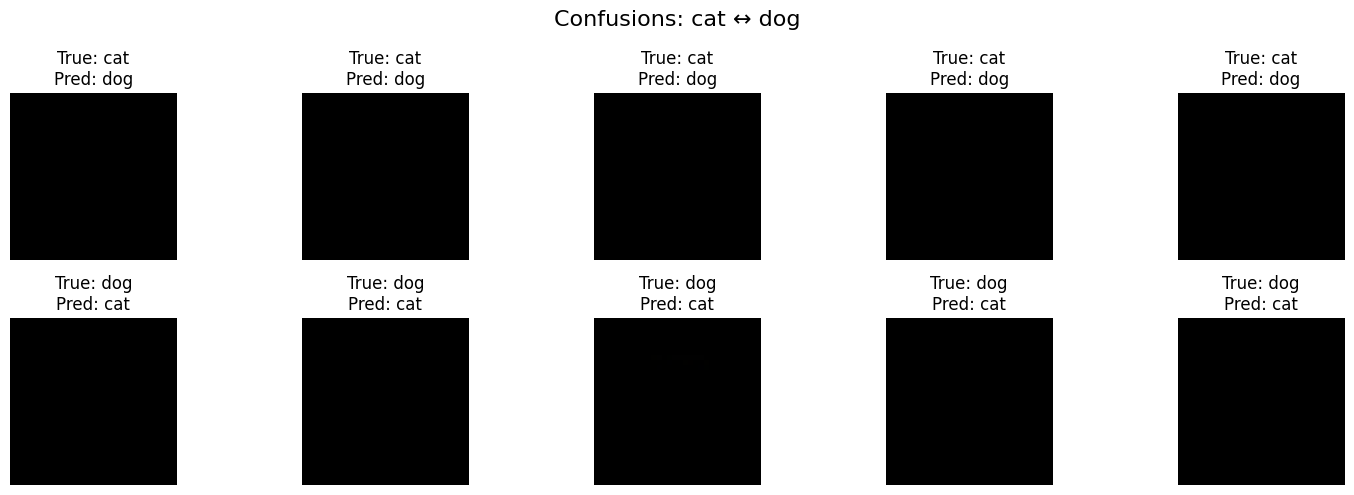

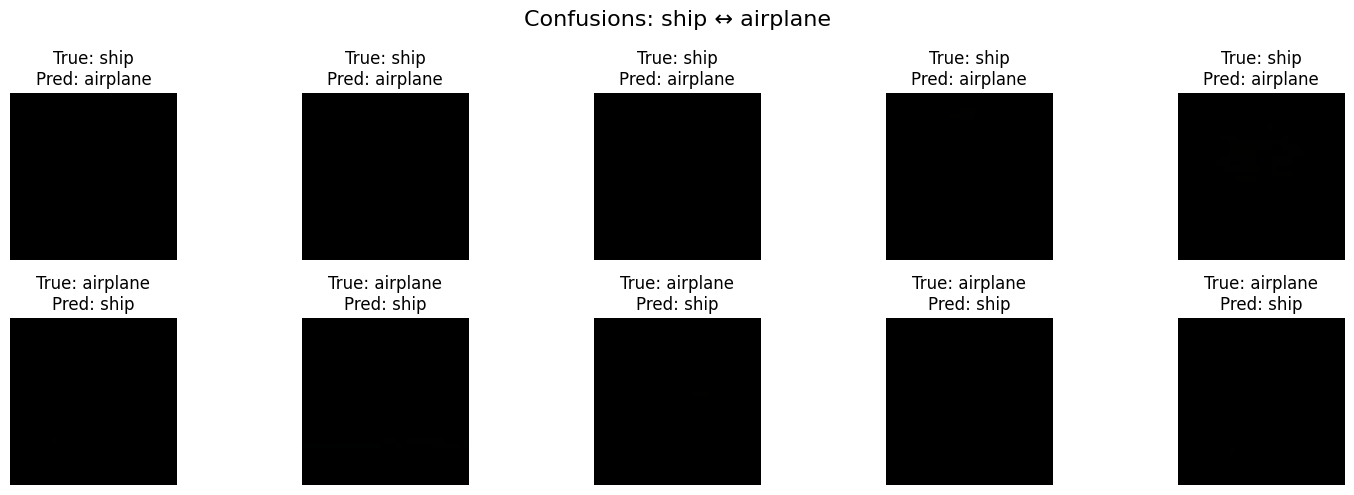

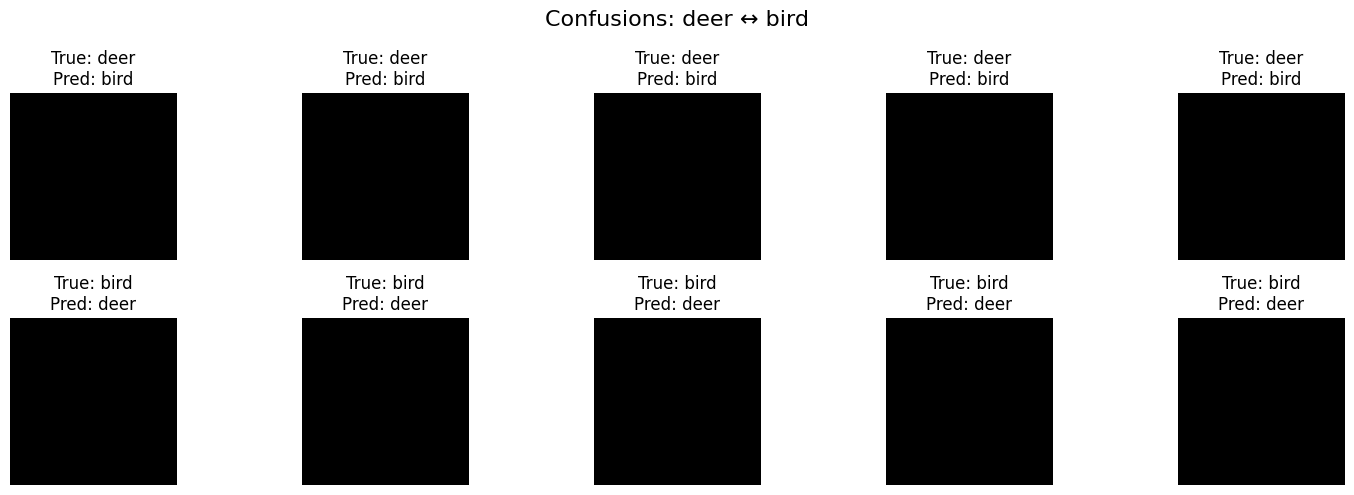

In [27]:
# y_pred and y_true to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Confusing class pairs to inspect
confusing_pairs = [
    (3, 5),  # cat vs dog
    (8, 0),  # ship vs airplane
    (4, 2)  # deer vs bird
]

def show_confusion_examples(y_true, y_pred, X, class1, class2, n=5):
    idx_confused_1 = np.where((y_true == class1) & (y_pred == class2))[0]
    idx_confused_2 = np.where((y_true == class2) & (y_pred == class1))[0]

    np.random.shuffle(idx_confused_1)
    np.random.shuffle(idx_confused_2)

    fig, axes = plt.subplots(2, n, figsize=(15, 5))
    fig.suptitle(f"Confusions: {class_names[class1]} ↔ {class_names[class2]}", fontsize=16)

    for i in range(n):
        # True class1 predicted class2
        if i < len(idx_confused_1):
            ax = axes[0, i]
            img = X[idx_confused_1[i]]
            if not isinstance(img, np.ndarray):
                img = img.numpy()
            ax.imshow(np.clip(img / 255.0, 0, 1))
            ax.set_title(f"True: {class_names[class1]}\nPred: {class_names[class2]}")
            ax.axis('off')
        else:
            axes[0, i].axis('off')

        # True class2 predicted class1
        if i < len(idx_confused_2):
            ax = axes[1, i]
            img = X[idx_confused_2[i]]
            if not isinstance(img, np.ndarray):
                img = img.numpy()
            ax.imshow(np.clip(img / 255.0, 0, 1))
            ax.set_title(f"True: {class_names[class2]}\nPred: {class_names[class1]}")
            ax.axis('off')
        else:
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

for class1, class2 in confusing_pairs:
    show_confusion_examples(y_true, y_pred, X_test, class1, class2)

## 6. Improving CNN Models

#### 6.1 More Layers Version 1

In [29]:
model_ml_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


In [30]:
model_ml_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_ml_1 = model_ml_1.fit(X_train, y_train_cat, epochs=20, batch_size=64, validation_data=(X_test, y_test_cat), callbacks=[early_stop])
evaluate_model(model_ml_1, "CNN More Layers v1", X_test, y_test_cat)

# save baseline model
model_ml_1.save("CIFAR-10_cnn_ml_1.keras")

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2945 - loss: 1.8785 - val_accuracy: 0.5270 - val_loss: 1.3224
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5156 - loss: 1.3385 - val_accuracy: 0.5949 - val_loss: 1.1461
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5904 - loss: 1.1595 - val_accuracy: 0.6298 - val_loss: 1.0437
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6393 - loss: 1.0328 - val_accuracy: 0.6641 - val_loss: 0.9612
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6727 - loss: 0.9312 - val_accuracy: 0.6799 - val_loss: 0.9148
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7017 - loss: 0.8563 - val_accuracy: 0.6842 - val_loss: 0.9003
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7229 - loss: 0.7975 - val_accuracy: 0.6967 - val_loss: 0.8873
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7388 - loss: 0.7508 - val_accuracy: 

#### 6.2 More Layers Version 2

In [31]:
model_ml_2 = Sequential([
    Conv2D(32, (3,3), padding="same", input_shape=(32,32,3)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), padding="same"),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), padding="same"),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_ml_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_ml_2 = model_ml_2.fit(X_train, y_train_cat, epochs=60, batch_size=64, validation_data=(X_test, y_test_cat), callbacks=[early_stop])
evaluate_model(model_ml_2, "CNN More Layers v2", X_test, y_test_cat)

# save baseline model
model_ml_2.save("CIFAR-10_cnn_ml_2.keras")

Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3745 - loss: 1.7012 - val_accuracy: 0.4185 - val_loss: 1.6854
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5574 - loss: 1.2251 - val_accuracy: 0.4306 - val_loss: 1.5563
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6113 - loss: 1.0875 - val_accuracy: 0.5261 - val_loss: 1.2500
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6456 - loss: 0.9954 - val_accuracy: 0.5179 - val_loss: 1.3861
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6711 - loss: 0.9282 - val_accuracy: 0.4190 - val_loss: 1.8763
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6926 - loss: 0.8692 - val_accuracy: 0.5152 - val_loss: 1.5456
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7164 - loss: 0.8116 - val_accuracy: 0.5359 - val_loss: 1.5080
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7326 - loss: 0.7670 - val_accuracy: 

### 6.3 BatchNorm & GlobalAveragePooling



In [32]:
model_ml_2 = load_model("CIFAR-10_cnn_ml_2.keras")

model_ml_2_GAP = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])



In [33]:
model_ml_2_GAP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ml_2_GAP.fit(X_train, y_train_cat, epochs=60, batch_size=64, validation_data=(X_test, y_test_cat), callbacks=[early_stop])
evaluate_model(model_ml_2_GAP, "CNN More Layers v2 GAP", X_test, y_test_cat)
model_ml_2_GAP.save("CIFAR-10_cnn_ml_2_GAP.keras")

Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3785 - loss: 1.7007 - val_accuracy: 0.5033 - val_loss: 1.4317
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5644 - loss: 1.2107 - val_accuracy: 0.4779 - val_loss: 1.5457
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6153 - loss: 1.0736 - val_accuracy: 0.3885 - val_loss: 2.0166
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6472 - loss: 0.9867 - val_accuracy: 0.5393 - val_loss: 1.3631
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6758 - loss: 0.9120 - val_accuracy: 0.5468 - val_loss: 1.3603
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6952 - loss: 0.8597 - val_accuracy: 0.4580 - val_loss: 1.8713
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7158 - loss: 0.8122 - val_accuracy: 0.4839 - val_loss: 1.8278
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7309 - loss: 0.7663 - val_accuracy: 

### 6.4 Optimizer SGD

In [35]:
# Load pre-trained baseline model
model_sgd = load_model("CIFAR-10_base_model.keras")

# Re-compile with SGD optimizer
sgd_opt = SGD(learning_rate=1e-3, momentum=0.9)
model_sgd.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Continue training / fine-tuning with SGD
history_sgd = model_sgd.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop]
)

# Save & evaluate
model_sgd.save("CIFAR-10_base_model+SGD.keras")
evaluate_model(model_sgd, "Baseline + SGD", X_test, y_test_cat)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8529 - loss: 0.6156 - val_accuracy: 0.6538 - val_loss: 1.6430
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8746 - loss: 0.4802 - val_accuracy: 0.6612 - val_loss: 1.5255
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8794 - loss: 0.4437 - val_accuracy: 0.6637 - val_loss: 1.4734
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8847 - loss: 0.4220 - val_accuracy: 0.6644 - val_loss: 1.4402
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8896 - loss: 0.4061 - val_accuracy: 0.6657 - val_loss: 1.4212
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8929 - loss: 0.3936 - val_accuracy: 0.6689 - val_loss: 1.4106
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8952 - loss: 0.3840 - val_accuracy: 0.6702 - val_loss: 1.4025
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8978 - loss: 0.3740 - val_accuracy: 0

(array([3, 8, 1, ..., 2, 4, 7]), array([3, 8, 8, ..., 5, 1, 7]))

### 6.5 Evaluation comparison

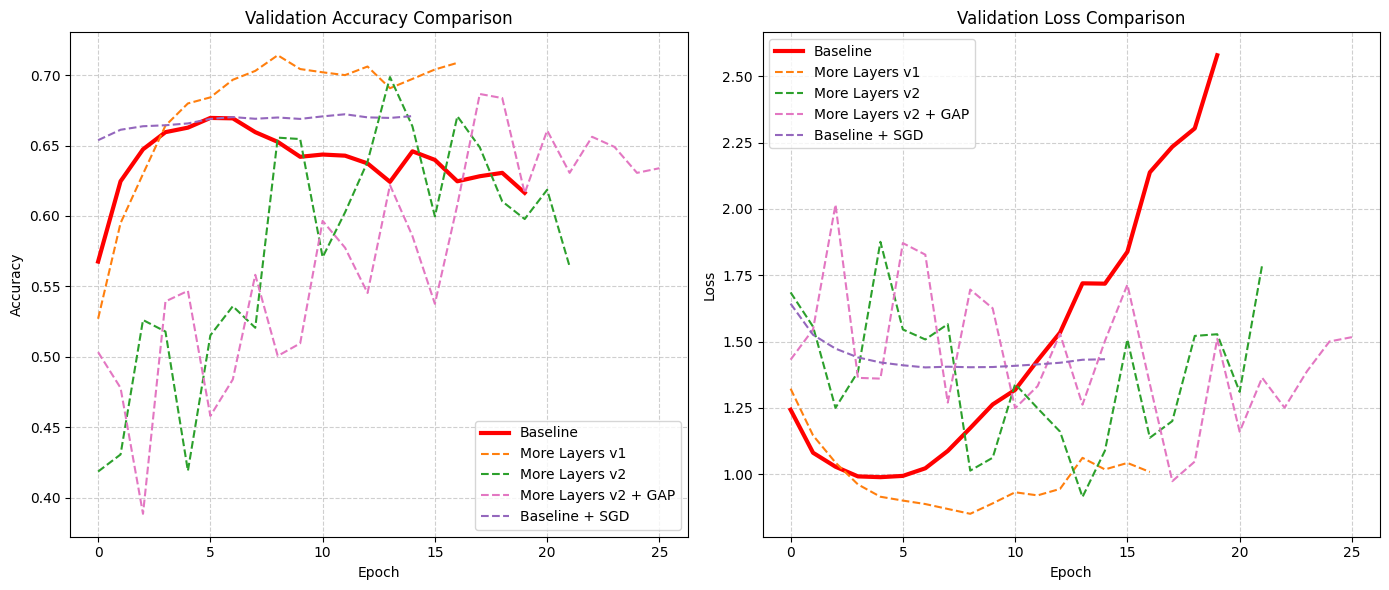

In [37]:
# Combine all histories in a dictionary for easy looping
histories = {
    "Baseline": history_base,
    "More Layers v1": history_ml_1,
    "More Layers v2": history_ml_2,
    "More Layers v2 + GAP": model_ml_2_GAP.history,
    "Baseline + SGD": model_sgd.history
}

plt.figure(figsize=(14, 6))

# Define styles: highlight baseline
styles = {
    "Baseline": {"color": "red", "linewidth": 3, "linestyle": "-"},
    "More Layers v1": {"color": "C1", "linewidth": 1.5, "linestyle": "--"},
    "More Layers v2": {"color": "C2", "linewidth": 1.5, "linestyle": "--"},
    "More Layers v2 + GAP": {"color": "C6", "linewidth": 1.5, "linestyle": "--"},
    "Baseline + SGD": {"color": "C4", "linewidth": 1.5, "linestyle": "--"},
}

# Accuracy Plot
plt.subplot(1, 2, 1)
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=f'{name}', **styles[name])
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss Plot
plt.subplot(1, 2, 2)
for name, hist in histories.items():
    plt.plot(hist.history['val_loss'], label=f'{name}', **styles[name])
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 7. Transfer Learning

In [41]:
# resize images to 96x96
X_train_resized = tf.image.resize(X_train, (96, 96)).numpy()
X_test_resized = tf.image.resize(X_test, (96, 96)).numpy()

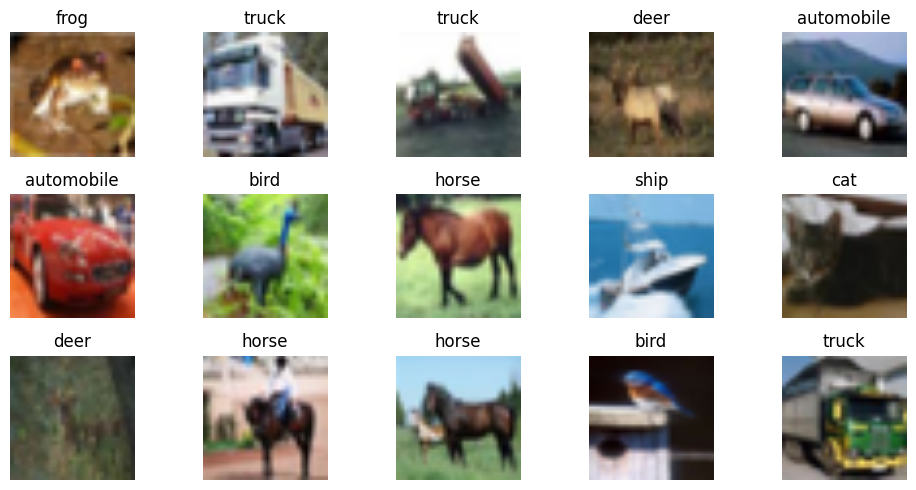

In [43]:
X_train_resized_int = tf.cast(X_train_resized * 255.0, tf.uint8).numpy()

# plot figure
plt.figure(figsize=(10, 5))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train_resized_int[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 7.1 MobileNetV2

In [81]:
# mobile net v2 model
mobilenet_base = MobileNetV2(input_shape=(96,96,3), include_top=False, weights='imagenet')

# freeze all layers
mobilenet_base.trainable = False

# add activation
model_mnet = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model_mnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mnet = model_mnet.fit(X_train_resized, y_train_cat, validation_split=0.2, epochs=60, batch_size=64, callbacks=[early_stop])
evaluate_model(model_mnet, "MobileNetV2 Frozen", X_test_resized, y_test_cat)


Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6872 - loss: 0.9073 - val_accuracy: 0.7923 - val_loss: 0.5971
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8050 - loss: 0.5612 - val_accuracy: 0.8019 - val_loss: 0.5693
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8285 - loss: 0.4946 - val_accuracy: 0.8007 - val_loss: 0.5637
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8469 - loss: 0.4424 - val_accuracy: 0.7972 - val_loss: 0.5769
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8628 - loss: 0.3995 - val_accuracy: 0.7913 - val_loss: 0.6084
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8752 - loss: 0.3624 - val_accuracy: 0.7858 - val_loss: 0.6400
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8904 - loss: 0.3258 - val_accuracy: 0.7840 - val_loss: 0.6755
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9007 - loss: 0.2959 - val_acc

(array([3, 8, 8, ..., 5, 1, 7]), array([3, 8, 8, ..., 5, 1, 7]))

#### 7.1.1 MobilNetV2 with unfrozen layers

In [29]:
# load model
model_mnet_unfreeze = load_model("MobileNetV2_Frozen.keras")

# acces base
mobilenet_base = model_mnet_unfreeze.layers[0]

# unfreeze the last 60 layers
for layer in mobilenet_base.layers[:-60]:
    layer.trainable = False
for layer in mobilenet_base.layers[-60:]:
    layer.trainable = True

In [31]:
# re-compile w low leanring rate
model_mnet_unfreeze.compile(
    optimizer=Adam(1e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [32]:
# continue training (fine-tuning)
history_finetune = model_mnet_unfreeze.fit(
    X_train_resized, y_train_cat,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    callbacks=[early_stop]
)

# Evaluate
evaluate_model(model_mnet_unfreeze, "MobileNetV2 Fine-Tuned", X_test_resized, y_test_cat)

# save
model_mnet_unfreeze.save("MobileNetV2_FineTuned.keras")

Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.6966 - loss: 0.9910 - val_accuracy: 0.8121 - val_loss: 0.5858
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8373 - loss: 0.4937 - val_accuracy: 0.8422 - val_loss: 0.4917
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8842 - loss: 0.3533 - val_accuracy: 0.8538 - val_loss: 0.4584
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9168 - loss: 0.2618 - val_accuracy: 0.8572 - val_loss: 0.4495
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9440 - loss: 0.1938 - val_accuracy: 0.8584 - val_loss: 0.4537
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9639 - loss: 0.1412 - val_accuracy: 0.8600 - val_loss: 0.4610
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9779 - loss: 0.1000 - val_accuracy: 0.8616 - val_loss: 0.4705
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9891 - loss: 0.0684 - 

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=MobileNetV2_FineTuned.

### 7.2 DenseNet121

In [49]:
# batch-wise resizing images to 224x224

# set parameters
IMG_SIZE = 224
batch_size = 64

#preprocessing function
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = preprocess_input(image)
    return image, label

# dataset
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
            .shuffle(10000)
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

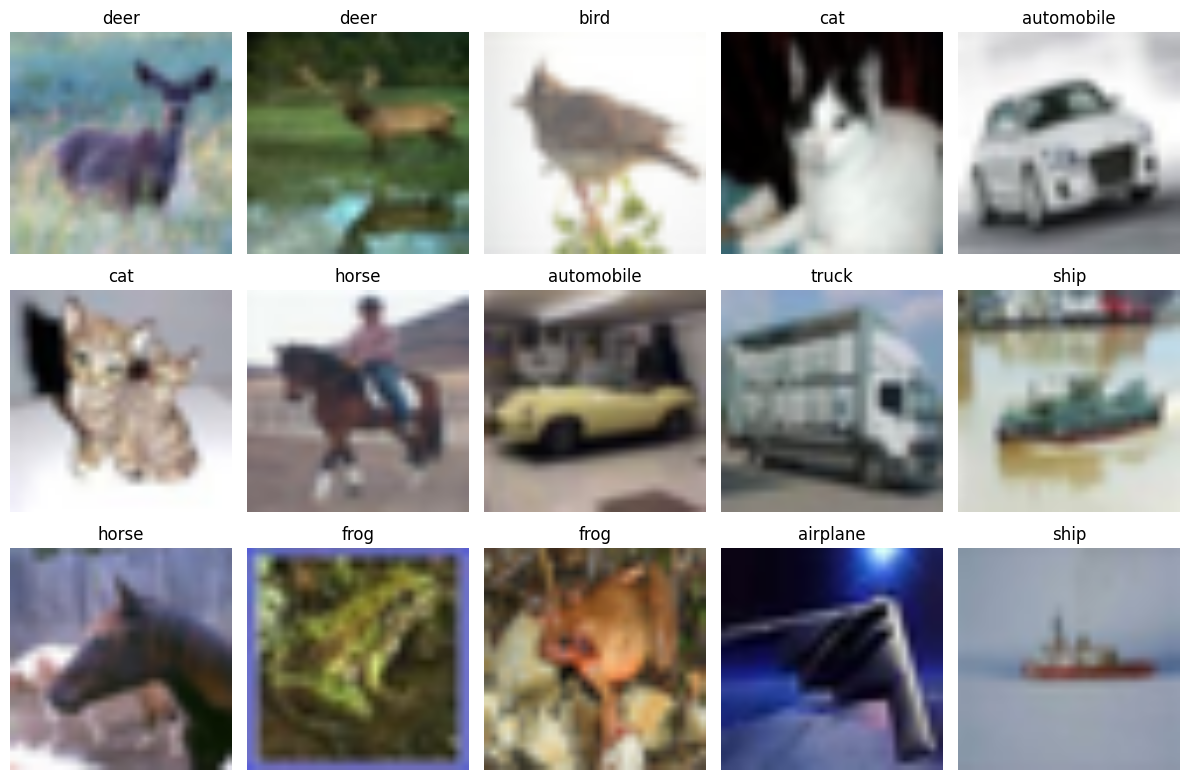

In [34]:
# take one batch from dataset
images, labels = next(iter(train_ds))

# convert tensors to numpy for plotting
images = images.numpy()
labels = labels.numpy()

# plot first 15 images (3 rows x 5 columns)
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

#### 7.2.1 DenseNet121 Frozen

In [47]:
densenet_base = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

densenet_base.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [50]:
# add activation layers
model_dennet121 = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model_dennet121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mnet = model_dennet121.fit(train_ds, validation_data=test_ds, epochs=60, batch_size=64, callbacks=[early_stop])
evaluate_model(model_dennet121, "DenseNet121 Frozen", test_ds)


Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 138ms/step - accuracy: 0.7070 - loss: 0.8608 - val_accuracy: 0.8023 - val_loss: 0.5653
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.8221 - loss: 0.5125 - val_accuracy: 0.8318 - val_loss: 0.4934
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.8364 - loss: 0.4715 - val_accuracy: 0.8257 - val_loss: 0.5090
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8464 - loss: 0.4457 - val_accuracy: 0.8323 - val_loss: 0.4854
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8519 - loss: 0.4201 - val_accuracy: 0.8348 - val_loss: 0.4842
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8588 - loss: 0.3998 - val_accuracy: 0.8378 - val_loss: 0.4790
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8657 - loss: 0.3781 - val_accuracy: 0.8348 - val_loss: 0.4811
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8730 - loss: 0.3596 

(None, None)

In [51]:
# save
model_dennet121.save("DenseNet121_Freeze.keras")

#### 7.2.2 DenseNet Fine Tuning

In [52]:
# load model
model_dennet121_unfreeze = load_model("DenseNet121_Freeze.keras")

# acces base
dennet_base = model_dennet121_unfreeze.layers[0]

# unfreeze the last 60 layers
for layer in dennet_base.layers[:-60]:
    layer.trainable = False
for layer in dennet_base.layers[-60:]:
    layer.trainable = True

In [53]:
# re-compile w low leanring rate
model_dennet121_unfreeze.compile(
    optimizer=Adam(1e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [57]:

model_dennet121_unfreeze.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mnet = model_dennet121_unfreeze.fit(train_ds, validation_data=test_ds, epochs=60, batch_size=64, callbacks=[early_stop])
evaluate_model(model_dennet121_unfreeze, "DenseNet121 FineTuned", test_ds)
model_dennet121_unfreeze.save("DenseNet121_FineTuned.keras")


Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 152ms/step - accuracy: 0.8279 - loss: 0.5223 - val_accuracy: 0.8581 - val_loss: 0.4093
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.8978 - loss: 0.2923 - val_accuracy: 0.8830 - val_loss: 0.3616
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9235 - loss: 0.2119 - val_accuracy: 0.8803 - val_loss: 0.3877
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9447 - loss: 0.1546 - val_accuracy: 0.8841 - val_loss: 0.3920
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9552 - loss: 0.1286 - val_accuracy: 0.8864 - val_loss: 0.4293
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9620 - loss: 0.1043 - val_accuracy: 0.8894 - val_loss: 0.4070
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9691 - loss: 0.0856 - val_accuracy: 0.8884 - val_loss: 0.4638
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - accuracy: 0.9725 - loss: 0.0737 

### 7.3 DenseNet121 Fine Tune with Augmentation

In [44]:
# batch-wise resizing images to 224x224

# set parameters
IMG_SIZE = 224
batch_size = 64

# augmenation
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# preprocessing
def preprocess_aug(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# dataset augmentation applied
train_ds_aug = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
    .shuffle(10000)
    .map(preprocess_aug, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (data_aug(x, training=True), y))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds_aug = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
    .map(preprocess_aug, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

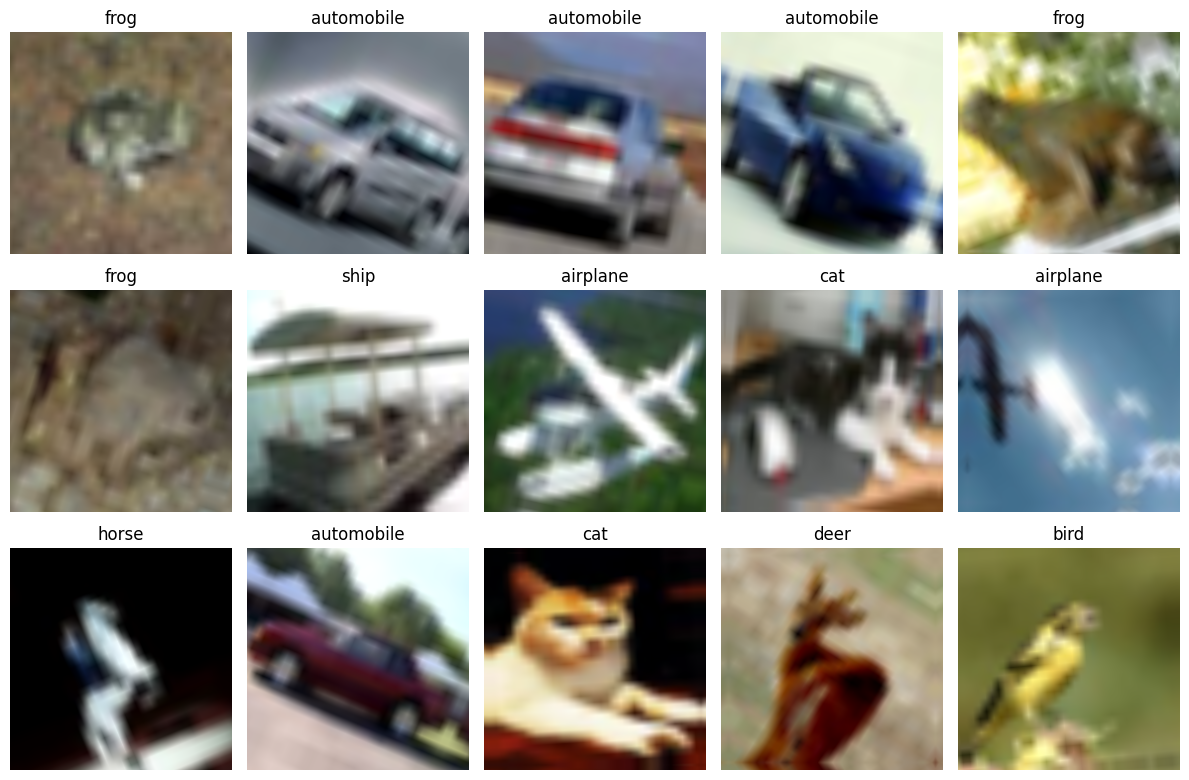

In [46]:
# take one batch
images, labels = next(iter(train_ds_aug))

# convert tensors to numpy
images = images.numpy()
labels = labels.numpy()

# plot first 15 images
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])  # keep float32 [0,1], no cast needed
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# load base model
densenet_base = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# laszt 60 layer unfrozen
for layer in densenet_base.layers[:-60]:
    layer.trainable = False
for layer in densenet_base.layers[-60:]:
    layer.trainable = True

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [14]:
# build model
model_dense_aug = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(10, activation='softmax')
])


In [15]:
# compile
model_dense_aug.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fit model
history_dense_aug = model_dense_aug.fit(
    train_ds_aug,
    validation_data=test_ds_aug,
    epochs=60,
    callbacks=[early_stop]
)

# Evaluate
evaluate_model(model_dense_aug, "DenseNet121 + Augmentation", test_ds_aug)


Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 725s 857ms/step - accuracy: 0.2191 - loss: 2.6763 - val_accuracy: 0.6189 - val_loss: 1.1450
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 621s 794ms/step - accuracy: 0.5175 - loss: 1.4462 - val_accuracy: 0.7169 - val_loss: 0.8493
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 621s 794ms/step - accuracy: 0.6087 - loss: 1.1663 - val_accuracy: 0.7603 - val_loss: 0.7216
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 620s 793ms/step - accuracy: 0.6562 - loss: 1.0199 - val_accuracy: 0.7828 - val_loss: 0.6505
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 620s 793ms/step - accuracy: 0.6872 - loss: 0.9300 - val_accuracy: 0.8012 - val_loss: 0.5974
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 620s 793ms/step - accuracy: 0.7120 - loss: 0.8511 - val_accuracy: 0.8119 - val_loss: 0.5602
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 621s 794ms/step - accuracy: 0.7318 - loss: 0.7897 - val_accuracy: 0.8209 - val_loss: 0.5335
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 620s 793ms/step - accuracy: 0.7399 -

KeyboardInterrupt: 

## 8. Summary Table

In [88]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="Accuracy", ascending=False)
display(df_results)

#df_results.to_csv("cifar10_model_results.csv", index=False)

KeyError: 'Accuracy'